<a href="https://colab.research.google.com/github/sophie-bickford/PBIML-Forest-Fires/blob/main/Forest_Fires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Fires

####Background Information and Introduction to Forest Fires Dataset:

Persona: Our aim is to calculate the risk of forest fires and predict whether an area, given certain environmental factors, is likely to be heavily affected by fire. Although our dataset only includes data on one park, the results of this project can be applied to other forest locations as we build up a comprehensive understanding of our data variables and their impact on forest fire predictions.

The main challenge of this project is dealing with overfitting. Given that the dimensions of our dataset are 517 rows and 12 columns, the high dimensionality may lead to overfitting.
In addition, several of our variables are skewed, so we would need to find solutions for normalization.

Variables:
- X: x-axis coordinate within the park (int, 1-9)
- Y: y-axis coordinate within the park (int, 2-9)
- month: month of the year (string)
- day: day of the week (string)
- FFMC: Fine Fuel Moisture Code, moisture content in litter and other fine fuels. Indicates how easily fine fuel ignites and burns. (double)
- DMC: Duff Moisture Code, moisture content in duff (coniferous needles, lightly compacted on the ground, see: https://en.wikipedia.org/wiki/Wildfire#Spread) (double).
- DC: Drought Code, avg moisture of deep, organic layers. Useful to understand drought effects on fuel in forest
- ISI: Initial Spread Index, expected rate of fire spread, based on wind and FFMC, but does not take fuel types into account
- temp: temperature in degrees Celsius
- RH: relative humidity, %
- wind: wind speed, km/h
- rain: amount of rain in millimeters/square meter
- area: TARGET VARIABLE, the burned area of the forest sector in hectares (10,000 square meters, 1/100th of a square kilometer)


Additionally, see https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi
https://archive.ics.uci.edu/dataset/162/forest+fires

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("drive/MyDrive/Bickford - PBIML")

In [ ]:
import os
os.chdir("drive/MyDrive/Ian_PBIML")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('forestfires.csv')

In [ ]:
#display the first few rows of the dataset
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


#### Exploratory Data Analysis (EDA) & Preprocessing

In [ ]:
data['month'].value_counts()

month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: count, dtype: int64

In [ ]:
# replace the month column with the binary fire season column
fire_season = []
fire_season_months = ['jul', 'aug', 'sep']

for index, row in data.iterrows():
  fire_season.append(int(row['month'] in fire_season_months))


data['fire season'] = fire_season

In [ ]:
data['fire season'].value_counts()

fire season
1    388
0    129
Name: count, dtype: int64

We decided to replace the month column with a binary "fire season" column, displaying whether the observation was taken during fire season in Portugal, which is from July through September. We initially considered either label encoding or one hot encoding the column. However, label encoding may create linear relationships that are not actually present in the data, and one hot encoding would create 12 additional columns, increasing dimensionality and potentially leading to overfitting.

In [ ]:
data['rain'].describe()

count    517.000000
mean       0.021663
std        0.295959
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.400000
Name: rain, dtype: float64

In [ ]:
data[data['rain'] > 0]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,fire season
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0
243,7,4,aug,sun,91.8,175.1,700.7,13.8,21.9,73,7.6,1.0,0.00,1
286,7,6,jul,wed,91.2,183.1,437.7,12.5,12.6,90,7.6,0.2,0.00,1
499,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82,1
500,8,6,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00,1
501,7,5,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00,1
502,4,4,aug,tue,96.1,181.1,671.2,14.3,20.7,69,4.9,0.4,0.00,1
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17,1


In [ ]:
# drop locational/temporal columns and rain column (which has 8 nonzero values)
data = data.drop(['X', 'Y', 'month', 'day', 'rain'], axis=1)

We also dropped the X and Y columns because they are locational and could be misleading in our analysis. The month column has been replaced with the fire season column, and the day column is irrelevant because the day of the week should not be correlated with when fires occur. Moreover, we hypothesized that data was likely collected once a week (probably on weekends), and collected more frequently during the week if a fire is present. Therefore, the day column should not be considered in our analysis. The rain column was also excluded because it has only 8 non-zero values (see above).

In [ ]:
data.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,area,fire season
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0


In [ ]:
data['area'].describe()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

In [ ]:
# replace the continuous area column with a binary column based on whether area value is nonzero
is_burned = []

for index, row in data.iterrows():
  is_burned.append(int(row['area'] != 0))

data['area'] = is_burned
data.rename(columns={'area': 'burned'}, inplace=True)

In [ ]:
data['burned'].value_counts()

burned
1    270
0    247
Name: count, dtype: int64

We determined that the area column, which is the target variable, is mostly comprised of zeroes. Because of this, and in addition to our original goal of finding which areas are burned, we decided to make a new categorical target variable, displaying whether or not there is *any* burned area in the forest sector.

#### Variable Correlation Analysis

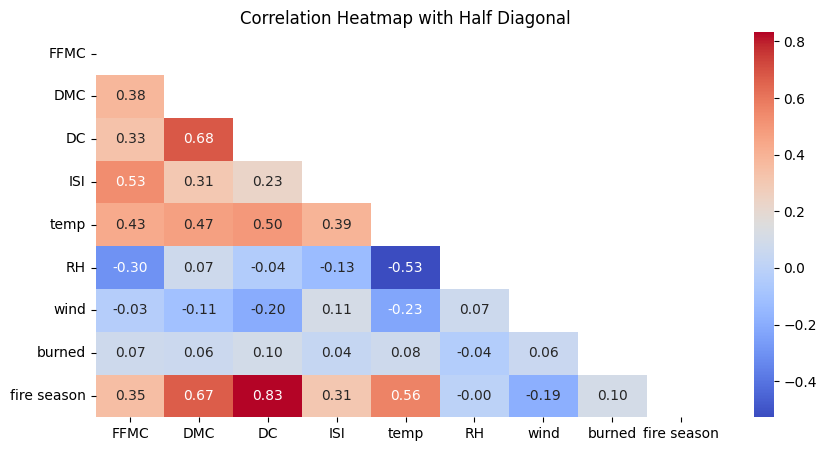

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = np.corrcoef(data, rowvar=False)

# Create a mask to hide the upper triangle and the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)

# Use Seaborn to plot the heatmap with the mask
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=data.columns,
            yticklabels=data.columns)
plt.title("Correlation Heatmap with Half Diagonal")
plt.show()

In [ ]:
data['temp'].corr(data['RH'])

-0.5273903386376693

In [ ]:
data['FFMC'].corr(data['ISI'])

0.5318049310435652

In [ ]:
data['DMC'].corr(data['DC'])

0.6821916119833167

In [ ]:
data['fire season'].corr(data['DC'])

0.8320181110584011

Looking at the correlation matrix, we noticed high correlations between the Fire Weather Index (FWI) metrics and the newly engineered fire season column. We determined that the FWI metrics are likely highly correlated with each other because combinations of the same environmental variables (soil/leaf litter dryness, wind speed, etc.) are used to calculate them. These conditions are also likely to happen in certain times of year, hence the correlation with the fire season column.

####Outlier Removal

In [ ]:
data[data['ISI']>30]

,FFMC,DMC,DC,ISI,temp,RH,wind,burned,fire season
22,94.3,96.3,200.0,56.1,21.0,44,4.5,0,0


In [ ]:
data = data[data['ISI']<30]

The one extreme outlier in the ISI column has been removed via row deletion. Nothing else about the row in question was anomalous, leaving the outlier completely unexplained, so we decided to remove the row entirely.

In [ ]:
data.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,burned,fire season
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0,0


#### Normalization and Min-Max Scaling

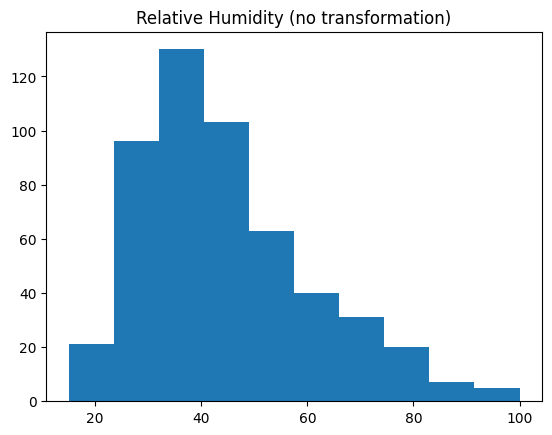

In [ ]:
plt.hist(data['RH'])
plt.title('Relative Humidity (no transformation)')
plt.show()

As we discovered in our initial EDA, the features in our dataset are not very normally distributed. For example, the RH (relative humidity) column is clearly right skewed.

In [ ]:
from scipy.stats import boxcox

data['RH'], _ = boxcox(data['RH'])

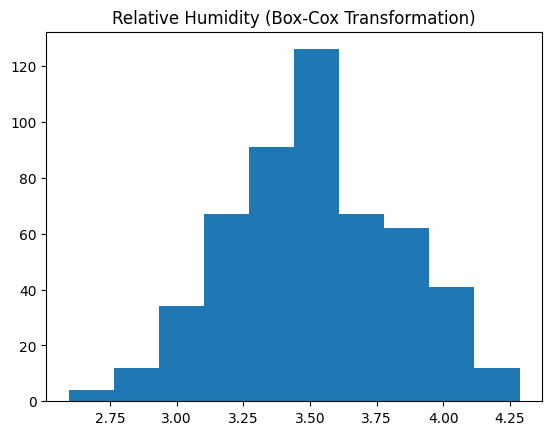

In [ ]:
plt.hist(data['RH'])
plt.title('Relative Humidity (Box-Cox Transformation)')
plt.show()

In [ ]:
# transform the remaining columns with continuous values
from scipy.stats import boxcox
from scipy.stats import yeojohnson

data['FFMC'], _ = boxcox(data['FFMC'])
data['DMC'], _ = boxcox(data['DMC'])
data['DC'], _ = boxcox(data['DC'])
data['ISI'], _ = yeojohnson(data['ISI'])
data['temp'], _ = boxcox(data['temp'])
#data['RH'], _ = boxcox(data['RH'])
data['wind'], _ = boxcox(data['wind'])

In [ ]:
# min max scale all columns with continuous values
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data['FFMC'] = scaler.fit_transform(data[['FFMC']])
data['DMC'] = scaler.fit_transform(data[['DMC']])
data['DC'] = scaler.fit_transform(data[['DC']])
data['ISI'] = scaler.fit_transform(data[['ISI']])
data['temp'] = scaler.fit_transform(data[['temp']])
data['RH'] = scaler.fit_transform(data[['RH']])
data['wind'] = scaler.fit_transform(data[['wind']])

Through our analysis, we discovered that none of the variables are adequately normally distributed (some more so than others). In order to ensure that all of our columns are relatively normally distributed, we utilized Box-Cox and Yeo Johnson transformations. It has a very clear effect, even on a very right skewed column (see graph above). We also scaled the data using min max scaling so that every variable will be considered equally by the model.

In [ ]:
data.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,burned,fire season
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,0.533088,0.502195,0.561064,0.513020,0.479331,0.542736,0.547042,0.523256,0.751938
std,0.194306,0.214703,0.291462,0.172419,0.191710,0.190100,0.186101,0.499944,0.432307
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.441692,0.374726,0.378169,0.419098,0.359296,0.418832,0.421036,0.000000,1.000000
50%,0.537022,0.519134,0.687002,0.505706,0.484833,0.543833,0.567348,1.000000,1.000000
75%,0.642169,0.623491,0.762752,0.600905,0.606482,0.672006,0.654525,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Split the data into train & test sets with a 80:20 split
from sklearn.model_selection import train_test_split
input_features = data.drop(columns=['burned'])
target = data['burned']

X_train, X_test, y_train, y_test = train_test_split(input_features, target, test_size=0.2, stratify = target, random_state=42)

Since we have completed our EDA and normalized our data, we are now ready to move on to the model creation and analysis phases of our project. Here we split the data into train and test sets.

##Model 1: Logistic Regression

Logistic regression was one of the first models we learned for classification, and because it is relatively computationally simple, we decided that it would be a good first step to developing a robust set of models.

With logistic regression, we not only develop a binary classification model that definitively classifies observations into two classes, but the model also makes classification decisions based on a percentage on how confident it is about a certain classification. This way, we can set our own decision threshold that determines the percentage at which we believe it is best to distinguish our two classes.

In [ ]:
from sklearn.model_selection import train_test_split
input_features = data.drop(columns=['burned'])
target = data['burned']

X_train, X_test, y_train, y_test = train_test_split(input_features, target, test_size=0.2, stratify = target, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=45,max_iter =10000,solver='liblinear')

We are setting solver to liblinear because liblinear is best at dealing with small datasets, such as the one we are analyzing.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516 entries, 0 to 516
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FFMC         516 non-null    float64
 1   DMC          516 non-null    float64
 2   DC           516 non-null    float64
 3   ISI          516 non-null    float64
 4   temp         516 non-null    float64
 5   RH           516 non-null    float64
 6   wind         516 non-null    float64
 7   burned       516 non-null    int64  
 8   fire season  516 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 40.3 KB


In [ ]:
# Train the classifier on the training data
clf.fit(X_train, y_train)


# Make predictions on the train data
y_train_pred = clf.predict(X_train)

# Make predictions on the test data
y_test_pred = clf.predict(X_test)

In [ ]:
y_probs = clf.predict_proba(X_train)[:,1]
print(y_probs)

[0.55064958 0.55538256 0.53815409 0.47972185 0.57952442 0.47259268
 0.59920541 0.50208604 0.56005839 0.56751476 0.60125058 0.57581686
 0.56700749 0.5256015  0.53321332 0.56934977 0.52419902 0.51149986
 0.52461613 0.50598799 0.53266856 0.53598787 0.51495704 0.56852572
 0.49023543 0.5431655  0.5853532  0.51436771 0.56088448 0.4791462
 0.53224754 0.56365393 0.43190061 0.46606123 0.51045444 0.47379993
 0.5668822  0.47327837 0.47658223 0.53644429 0.52545269 0.57013631
 0.52928087 0.50652421 0.55227354 0.55586155 0.56759554 0.49599509
 0.56598935 0.52728998 0.55880246 0.5750119  0.53600649 0.56697409
 0.51370525 0.4341447  0.57935085 0.53516773 0.52694198 0.5749062
 0.52029514 0.46579156 0.56023507 0.45904366 0.57876125 0.55304416
 0.58165563 0.44669389 0.52141467 0.52577544 0.56463567 0.5110489
 0.53165518 0.55380783 0.54114364 0.55188467 0.55608153 0.48349506
 0.55972464 0.49646911 0.55461483 0.53685565 0.59178391 0.48149226
 0.51113936 0.44326287 0.46120633 0.47737619 0.56623827 0.4172462

In [ ]:
decision_threshold = 0.6
predictions = [1 if pred_ >= decision_threshold else 0 for pred_ in y_probs]

The above code is simply an example of how we can set a decision threshold, but below we will see how various evaluation metrics change based on different thresholds, thus providing us with a comprehensive understanding of which threshold is best for our data and model.

In [ ]:
from sklearn.metrics import *

print(f"Accuracy (Train set): {accuracy_score(y_train, y_train_pred)}")
print(f"Accuracy (Test set): {accuracy_score(y_test, y_test_pred)}")
print(f"Accuracy score: {accuracy_score(y_train,predictions)}")

Accuracy (Train set): 0.5436893203883495
Accuracy (Test set): 0.5865384615384616
Accuracy score: 0.47815533980582525


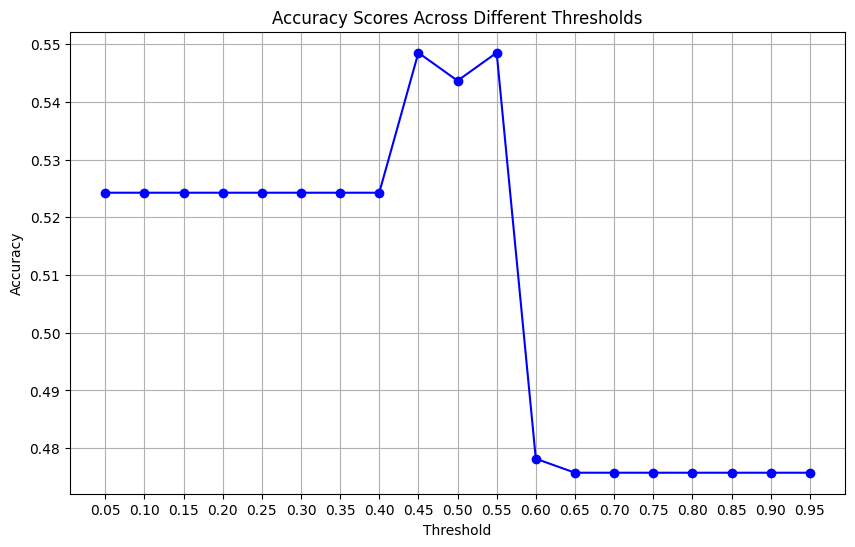

In [ ]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
accuracies = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    accuracies.append(accuracy_score(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

Accuracy peaks at 0.45 and 0.55

In [ ]:
print(f"Precision (Train set): {precision_score(y_train, y_train_pred)}")
print(f"Precision (Test set): {precision_score(y_test, y_test_pred)}")

Precision (Train set): 0.5454545454545454
Precision (Test set): 0.5753424657534246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

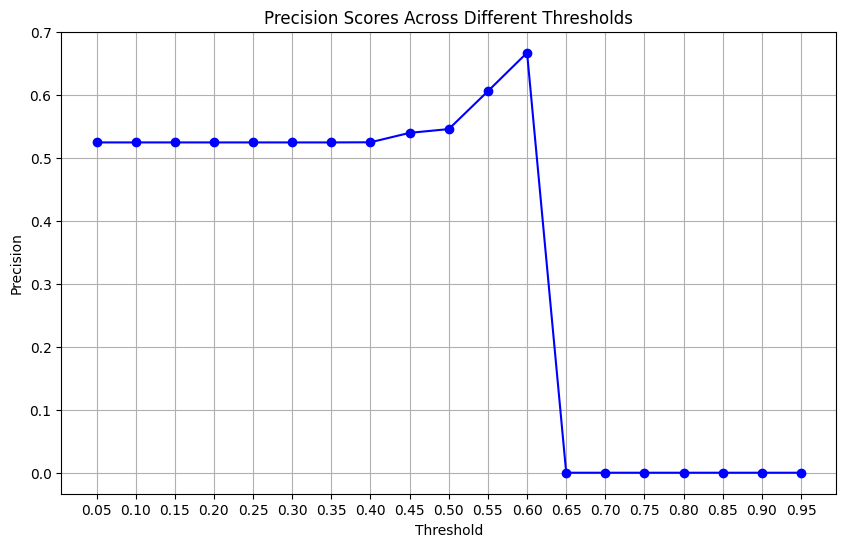

In [ ]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
precision = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    precision.append(precision_score(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, marker='o', linestyle='-', color='b')
plt.title('Precision Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

Precision peaks at 0.6. Anything after 0.6 results in an unfavorable precision score.

In [ ]:
print(f"Recall (Train set): {recall_score(y_train, y_train_pred)}")
print(f"Recall (Test set): {recall_score(y_test, y_test_pred)}")

Recall (Train set): 0.7777777777777778
Recall (Test set): 0.7777777777777778


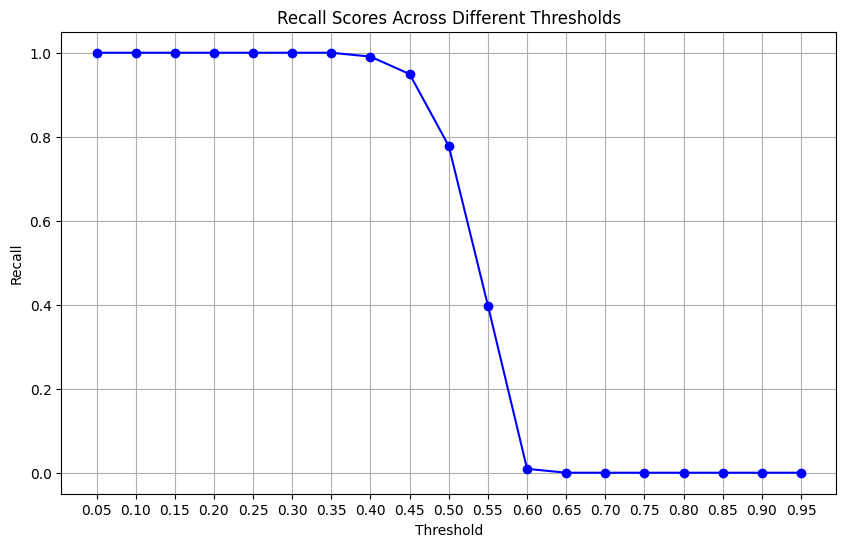

In [ ]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
recall = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    recall.append(recall_score(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall, marker='o', linestyle='-', color='b')
plt.title('Recall Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

Recall is best from 0.05 to 0.45, and decreases significantly thereafter.

In [ ]:
print(f"F1 Score (Train set): {f1_score(y_train, y_train_pred)}")
print(f"F1 Score (Test set): {f1_score(y_test, y_test_pred)}")

F1 Score (Train set): 0.6412213740458015
F1 Score (Test set): 0.6614173228346456


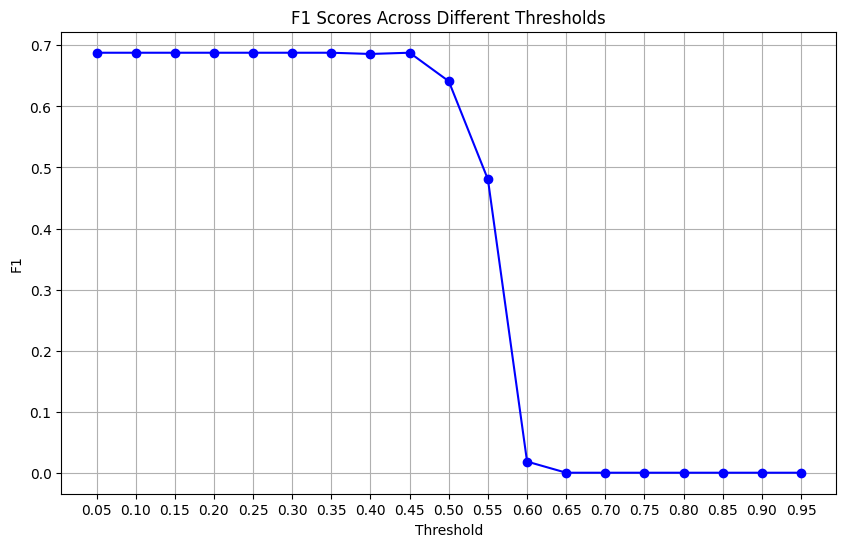

In [ ]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
f1 = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    f1.append(f1_score(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1, marker='o', linestyle='-', color='b')
plt.title('F1 Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

F1 score (the harmonic mean between precision and recall) basically combines the prior two results. Everything after 0.5 is unfavorable.

In [ ]:
print(f"ROC AUC Score (Train set): {roc_auc_score(y_train, y_train_pred)}")
print(f"ROC AUC Score (Test set): {roc_auc_score(y_test, y_test_pred)}")

ROC AUC Score (Train set): 0.5317460317460317
ROC AUC Score (Test set): 0.5788888888888889


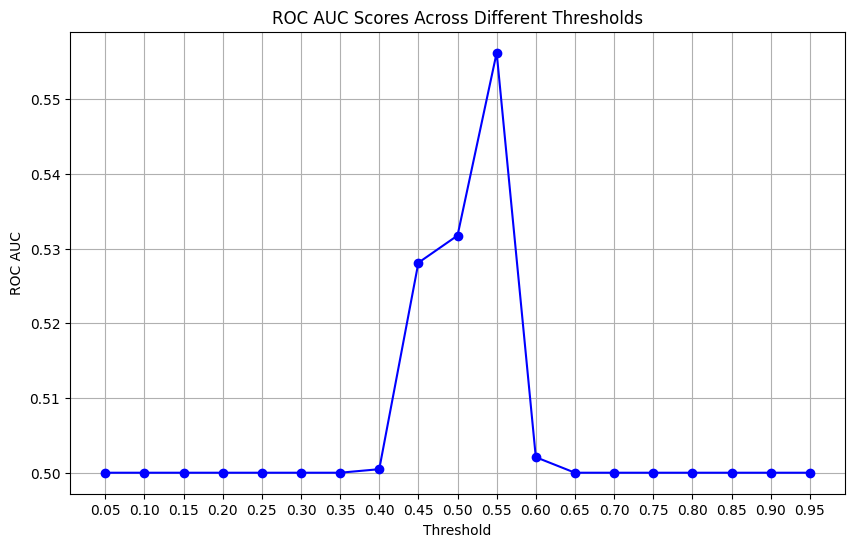

In [ ]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
auc = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    auc.append(roc_auc_score(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, auc, marker='o', linestyle='-', color='b')
plt.title('ROC AUC Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

ROC AUC peaks at 0.55, but 0.45 and 0.5 are also okay.

In [ ]:
print(f"Log Loss (Train set): {log_loss(y_train, y_train_pred)}")
print(f"Log Loss (Test set): {log_loss(y_test, y_test_pred)}")

Log Loss (Train set): 16.447103973674817
Log Loss (Test set): 14.902664382038823


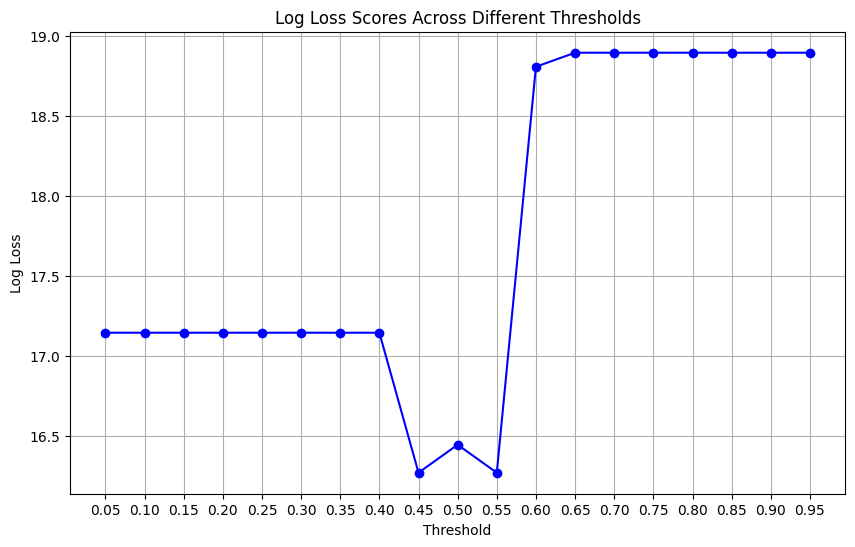

In [ ]:
thresholds = list(np.arange(0.05, 1, 0.05))

# Initialize empty lists to store accuracy scores
log_l = []

# Iterate through each K value and train a KNN classifier
for t in thresholds:
    predictions = [1 if pred_ >= t else 0 for pred_ in y_probs]
    log_l.append(log_loss(y_train,predictions))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, log_l, marker='o', linestyle='-', color='b')
plt.title('Log Loss Scores Across Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Log Loss')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

For log loss, we want the lowest score. Log loss is lowest at 0.45 and 0.55.

Given all of the results from the evaluation metrics, 0.45 is the best threshold. Even though this does not seem very far from 0.5 (the default threshold), a difference of 0.05 can make a significant difference in the model. We are trying to optimize everything as much as possible.

In [ ]:
y_probs = clf.predict_proba(X_test)[:,1]
print(y_probs)
decision_threshold = 0.45
predictions = [1 if pred_ >= decision_threshold else 0 for pred_ in y_probs]
print(f"Accuracy score: {accuracy_score(y_test,predictions)}")
print(f"Precision score: {precision_score(y_test,predictions)}")
print(f"Recall score: {recall_score(y_test,predictions)}")
print(f"F1 score: {f1_score(y_test,predictions)}")
print(f"ROC AUC score: {roc_auc_score(y_test,predictions)}")
print(f"Log loss score: {log_loss(y_test,predictions)}")

[0.45635803 0.52268611 0.55296958 0.55965089 0.50415773 0.48308482
 0.56952871 0.56620794 0.42530826 0.51550175 0.58258104 0.48593402
 0.54540836 0.57175913 0.53329921 0.53184673 0.60104304 0.52036427
 0.53499287 0.60697733 0.47344924 0.54787028 0.47596689 0.54033059
 0.57128242 0.48630085 0.53219272 0.4965839  0.50479502 0.51737494
 0.55253196 0.51372352 0.49105861 0.47379993 0.53683523 0.50111485
 0.52717334 0.60107987 0.5837072  0.57395912 0.55848022 0.493548
 0.59087945 0.54981332 0.5034084  0.5845164  0.53112988 0.46674333
 0.5545281  0.46002728 0.57142487 0.50740035 0.42390112 0.5279029
 0.52108199 0.5246944  0.46989244 0.56839493 0.45371194 0.43284488
 0.40453674 0.41615959 0.58233799 0.5837072  0.52484999 0.46214031
 0.5592621  0.53449505 0.53138983 0.48433186 0.5302866  0.5159906
 0.49613221 0.52314436 0.50386274 0.55211907 0.47392423 0.57239032
 0.59416127 0.49854043 0.52846334 0.53277723 0.49023543 0.46323333
 0.5527887  0.55611931 0.60952161 0.53053127 0.55523133 0.55676877

Although recall is very high (we do care about recall because wrongly predicting an area as not burnt can be adverse to the goals of this study), the other metrics are not optimal, indicating that logistic regression may not be the best approach to our study. Before moving on to our next model, let's apply some hyperparameter tuning to see if the model performs better.

###Hyperparameter Tuning

We will look at the hyperparameters penalty and C. Penalty determines whether the model will be regularized using L1 (Lasso) or L2 (Ridge) methods. C is the inverse of regularization strength. Both are useful in preventing overfitting.

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=12, shuffle=True)

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params_grid = grid_search.best_params_
best_score_grid = grid_search.best_score_

In [ ]:
print(best_params_grid)
print(best_score_grid)

{'C': 0.001, 'penalty': 'l2'}
0.524272700558331


In [ ]:
clf.set_params(penalty = 'l2', C=0.001)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train, y_train_pred)}')
print(f'Precision: {precision_score(y_train, y_train_pred)}')
print(f'Recall: {recall_score(y_train, y_train_pred)}')
print(f'F1 Score: {f1_score(y_train, y_train_pred)}')
print(f'ROC AUC: {roc_auc_score(y_train, y_train_pred)}')
print(f'Log Loss: {log_loss(y_train, y_train_pred)}')

Accuracy: 0.5242718446601942
Precision: 0.5242718446601942
Recall: 1.0
F1 Score: 0.6878980891719745
ROC AUC: 0.5
Log Loss: 17.146980738512042


In [ ]:
clf.fit(X_test,y_test)
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Log Loss: {log_loss(y_test, y_pred)}')

Accuracy: 0.5192307692307693
Precision: 0.5192307692307693
Recall: 1.0
F1 Score: 0.6835443037974684
ROC AUC: 0.5
Log Loss: 17.32867951399863


The model is not performing very well for either the train or test sets. Although recall remains high, the other metrics have unfavorable results.

##Model 2: Random Forest

The second model used in this study is Random Forest. Random Forest consists of multiple CARTs (Classification and Regression Trees) and is a common, robust model for classification. The benefits of Random Forest is that we can apply feature importance (to limit dimensionality and prevent overfitting), hyperparameter tuning (to optimize the various hyperparameters influencing our model), and pruning (also for preventing overfitting). Random Forest is also an ensemble method, meaning that we are taking the average results of our several Trees and providing comprehensive predictions and insights.

###Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# explore how accuracy changes at different values of n_estimators (10-100 trees)
for x in np.arange(10,100,10):
  RF_classifier =  RandomForestClassifier(n_estimators=x)
  RF_classifier.fit(X_train, y_train)
  y_pred_train = RF_classifier.predict(X_train)
  print(accuracy_score(y_train, y_pred_train))

0.9587378640776699
0.9733009708737864
0.9757281553398058
0.9757281553398058
0.9757281553398058
0.9757281553398058
0.9757281553398058
0.9757281553398058
0.9757281553398058


We examined how accuracy changes based on the number of trees in our random forest. We decided to do this prior to our grid search of other hyperparameters (see below) for the sake of computational efficiency. We determined that 40 estimators is the optimal value for maximizing efficiency and accuracy.

In [ ]:
RF_classifier =  RandomForestClassifier(n_estimators=40)
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=40)

In [ ]:
import seaborn as sns

# Get feature importances
feature_importances = RF_classifier.feature_importances_

# Print the importance of each feature
for feature, importance in zip(input_features.columns, feature_importances):
  print(f"{feature}: {importance:.4f}")

FFMC: 0.1162
DMC: 0.1330
DC: 0.1266
ISI: 0.1234
temp: 0.2023
RH: 0.1667
wind: 0.1221
fire season: 0.0095


In [ ]:
def plot_feature_importance(importance, names, model_name):
  #create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  # create a dataframe using a dictionary
  data = {'feature_names':feature_names, 'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)
  fi_df.sort_values(by=['feature_importance'],ascending = False, inplace=True)

  #define size of bar plot
  plt.figure(figsize=(10,8))
  sns.barplot(x=fi_df['feature_importance'], y = fi_df['feature_names'])
  plt.title(model_name + "FEATURE IMPORTANCE")

  #Add chart labels
  plt.xlabel("FEATURE IMPORTANCE")
  plt.ylabel("FEATURE NAMES")

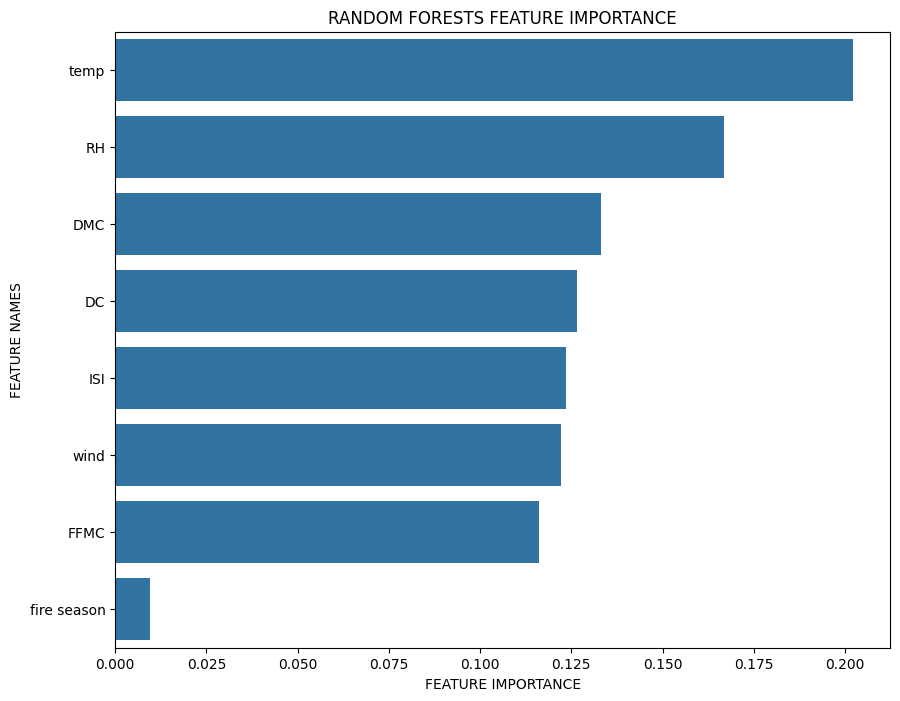

In [ ]:
plot_feature_importance(feature_importances , names = input_features.columns, model_name= "RANDOM FORESTS ")

In [ ]:
# drop the fire season column
try:
  data = data.drop(['fire season'],axis=1)
except:
  pass

In [ ]:
data.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,burned
0,0.248407,0.192908,0.039677,0.351356,0.142144,0.651921,0.806892,0
1,0.467200,0.239852,0.694361,0.429670,0.441072,0.422909,0.133123,0
2,0.467200,0.278483,0.721297,0.429670,0.330678,0.422909,0.213021,0
3,0.544509,0.229572,0.029590,0.531138,0.144854,0.984414,0.567348,0
4,0.388919,0.311561,0.044716,0.555938,0.232855,0.994859,0.296627,0


We first created a random forest model without setting any hyperparameters (with the exception of n_estimators for computational efficiency). We did this in order to take advantage of the built in variable importance methods, so we can eliminate unneeded features. The fire season column has extremely low (around 0.01) variable importance compared to the other features, which are each at least ten times more important, so we decided to eliminate it.

###Hyperparameter Tuning

Criterion determines which metric we will use to measure the purity of a node, max depth determines how many levels of nodes each tree can have, min samples split determines the minimum number of samples required to split an internal node, and max features determines the number of features to consider when looking for the best split.

In [ ]:
# parameters to be considered in the grid search
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(1,10,1),
    'min_samples_split': np.arange(2,10,1),
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=12, shuffle=True)

###Evil Grid Search (Do not run this if you don't have 5-10 mins to kill)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create a Grid Search object
grid_search = GridSearchCV(estimator=RF_classifier, param_grid=params, cv=skf, scoring='accuracy')

# Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from Grid Search
best_params_grid = grid_search.best_params_
best_score_grid = grid_search.best_score_

In [ ]:
print(best_params_grid)
print(best_score_grid)

{'criterion': 'log_loss', 'max_depth': 1, 'max_features': None, 'min_samples_split': 9}
0.5825741992359682


We conducted a grid search using Stratified K-fold cross validation in order to find the optimal hyperparameters for our random forest model. We concluded that the following hyperparameters were best: criterion = 'gini', max_depth = 2, max_features = None, min_samples_split = 3

###Hyperparameter Tuning (cont'd) & Pruning

{'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_split': 3}

Best Score: 0.5752571260652366

In [ ]:
RF_classifier_2 =  RandomForestClassifier(n_estimators=40, criterion='gini', min_samples_split=3)
RF_classifier_2.fit(X_test, y_test)
y_pred = RF_classifier_2.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9903846153846154


Since hyperparameter tuning resulted in a max depth of 2 (which seems odd), we wanted to apply methods of pruning to see whether there are other max depth values that would benefit the model without causing overfitting. We will also perform pruning for the hyperparameter min_samples_leaf

In [ ]:
RF_classifier_2.fit(X_train, y_train)
for x in range(5,100,5):
  RF_classifier_2.set_params(max_depth=x)

  # Evaluate the pruned Random Forest model
  accuracy = RF_classifier_2.score(X_train, y_train)
  print(RF_classifier_2.get_params()['max_depth'])
  print("Accuracy of pruned Random Forest:", accuracy)

5
Accuracy of pruned Random Forest: 0.9733009708737864
10
Accuracy of pruned Random Forest: 0.9733009708737864
15
Accuracy of pruned Random Forest: 0.9733009708737864
20
Accuracy of pruned Random Forest: 0.9733009708737864
25
Accuracy of pruned Random Forest: 0.9733009708737864
30
Accuracy of pruned Random Forest: 0.9733009708737864
35
Accuracy of pruned Random Forest: 0.9733009708737864
40
Accuracy of pruned Random Forest: 0.9733009708737864
45
Accuracy of pruned Random Forest: 0.9733009708737864
50
Accuracy of pruned Random Forest: 0.9733009708737864
55
Accuracy of pruned Random Forest: 0.9733009708737864
60
Accuracy of pruned Random Forest: 0.9733009708737864
65
Accuracy of pruned Random Forest: 0.9733009708737864
70
Accuracy of pruned Random Forest: 0.9733009708737864
75
Accuracy of pruned Random Forest: 0.9733009708737864
80
Accuracy of pruned Random Forest: 0.9733009708737864
85
Accuracy of pruned Random Forest: 0.9733009708737864
90
Accuracy of pruned Random Forest: 0.9733009708

In [ ]:
for x in range(1,10):
  RF_classifier_2.set_params(min_samples_leaf=x)

  # Evaluate the pruned Random Forest model
  accuracy = RF_classifier_2.score(X_train, y_train)
  print(RF_classifier_2.get_params()['min_samples_leaf'])
  print("Accuracy of pruned Random Forest:", accuracy)

1
Accuracy of pruned Random Forest: 0.9733009708737864
2
Accuracy of pruned Random Forest: 0.9733009708737864
3
Accuracy of pruned Random Forest: 0.9733009708737864
4
Accuracy of pruned Random Forest: 0.9733009708737864
5
Accuracy of pruned Random Forest: 0.9733009708737864
6
Accuracy of pruned Random Forest: 0.9733009708737864
7
Accuracy of pruned Random Forest: 0.9733009708737864
8
Accuracy of pruned Random Forest: 0.9733009708737864
9
Accuracy of pruned Random Forest: 0.9733009708737864


It seems as if pruning has no effect on the model (with respect to the parameters max_depth and min_samples_leaf). Therefore, we will set both to their default values: there will be no max_depth (the model is most likely not overfitting and can deal with a large max_depth), and min_samples_leaf will be its minimum value, 1.

In [ ]:
RF_classifier_2.set_params(max_depth=None,min_samples_leaf=1)
RF_classifier_2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 40,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
RF_classifier_2.fit(X_train,y_train)
y_train_pred = RF_classifier_2.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train, y_train_pred)}')
print(f'Precision: {precision_score(y_train, y_train_pred)}')
print(f'Recall: {recall_score(y_train, y_train_pred)}')
print(f'F1 Score: {f1_score(y_train, y_train_pred)}')
print(f'ROC AUC: {roc_auc_score(y_train, y_train_pred)}')
print(f'Log Loss: {log_loss(y_train, y_train_pred)}')

Accuracy: 0.9660194174757282
Precision: 0.9809523809523809
Recall: 0.9537037037037037
F1 Score: 0.9671361502347416
ROC AUC: 0.9666477702191988
Log Loss: 1.224784338465146


In [ ]:
RF_classifier_2.fit(X_test,y_test)
y_pred = RF_classifier_2.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Log Loss: {log_loss(y_test, y_pred)}')

Accuracy: 0.9807692307692307
Precision: 0.9642857142857143
Recall: 1.0
F1 Score: 0.9818181818181818
ROC AUC: 0.98
Log Loss: 0.6931471805599454


The results of Random Forest are significant! Accuracy, precision, recall, F1 score, and ROC-AUC are near 1, and log loss is near 0. Not only is this true for our train set, but also for our test set, meaning that our model is not overfitting.

##Conclusions:

####Summary of Findings:

We determined that weather factors such as temperature, relative humidity, and windspeed, combined with FWI metrics, are very effective in predicting whether an area will be burned in a forest fire. Temporal metrics proved to be mostly irrelevant, likely in part due to the data collection method of our dataset: each time a forest fire was recorded somewhere in the park, data was collected in every single forest quadrant. In other words, the frequency of fires during different seasons was not relevant because all data was taken from a point in time during which there was an active fire in some part of the park.

See: http://www3.dsi.uminho.pt/pcortez/fires.pdf for data collection information

####Insights and Interpretation:

We believe that this model and our findings can be generalized to other large forests of similar composition and climate, though some analysis should be done to conclusively study how well the model performs in areas with drastically different climate and/or forest composition. From the work we have done, we cannot confidently assess this particular question without further research and testing on other datasets.

We concluded that this model would be of particular use in remote areas with limited fire prevention and response resources. In these scenarios, determining which areas of a large forest are likely to be burned based on weather and FWI data can be used a useful tool for smart resource allocation, allowing local and government agencies to prioritize areas of forest that are more likely to need human intervention in order to prevent, slow, and eradicate forest fires.

####Limitations:
As discussed above, this model cannot necessarily be applied to forests or other ecosystems that are very different in climate or composition compared to the forest analyzed in this exploration. This is due to how fire spread metrics and weather conditions may differ in their interactions in an ecosystem with drastically different flora and fauna. In particular, the presence or absence of duff and brush layers would likely be heavy contributors to these differences, due to their roles in early stage wildfire spread.

The other main limitation of our model is in how our data was collected. As mentioned above, data was collected whenever a forest fire was present somewhere in the park. This means that we lack data from times when no fire was present anywhere in the park, so we cannot generalize our findings to data where no fire is present in the immediate geographic area.

####Future work:
In the future, we would like to examine the impact of similar metrics in other datasets featuring different climates and forest compositions. This would allow us to better generalize our findings to a wide variety of forests worldwide, and understand how interactions between our environmental variables change or remain constant in different areas. We would also like to explore the temporal aspect of this data more in depth, though this would require a different method of data collection, such as using environmental (weather and FWI) data taken at regular intervals throughout a long period of time. We would like to explore the impact of different times of year (which have different weather patterns) on forest fires, but also analyze how forest fire frequency and severity has changed over the past few decades. This would allow us to look at climate patterns as a whole, confronting the overall impact of climate change on forest fire frequency and intensity.